
#use multinomial naive bayes algorithm after the other models

# Imports

In [1]:
from pprint import pprint
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import acquire, prepare

## Term Frequency
`Raw Count`: This is simply the count of the number of occurances of each word.  
`Frequency`: The number of times each word appears divided by the total number of words.  
`Augmented Frequency`: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [2]:
document = 'Mary had a little lam, a little lam, a little lam.'

document = document.lower()\
                    .replace(',', ' ')\
                    .replace('.', '')
words = pd.Series(document.split())

#from series extra value counts (raw count of term frequency[TF]).
# can then us to calc other measures
(pd.DataFrame({'raw_count': words.value_counts()})
.assign(frequency=lambda df: df.raw_count / df.raw_count.sum()) # create frequency column
.assign(augmented_frequency=lambda df: df.frequency / df.frequency.max())) # create augmented frequency column

,raw_count,frequency,augmented_frequency
a,3,0.272727,1.000000
little,3,0.272727,1.000000
lam,3,0.272727,1.000000
mary,1,0.090909,0.333333
had,1,0.090909,0.333333


## Inverse Document Frequency
* must have multiple documents 
* provides ide of how much informationa word provides
* based on commonality of word appearance across docs
* higher freq == lower IDF

Text(0.5, 1.0, 'IDF for a given word')

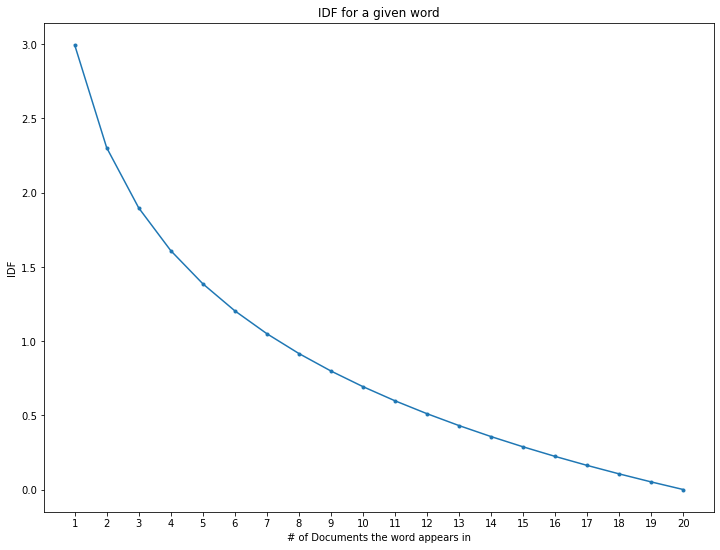

In [3]:
#example of relationship between frequency and IDF score
n_documents = 20

x = np.arange(1, n_documents +1)
y = np.log(n_documents / x)

plt.figure(figsize=(12,9))
plt.plot(x,y, marker='.')

plt.xticks(x)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

### Calculating IDF for multipel words

In [4]:
#generate 3 example documents
documents = {
    'news': 'Codeup announced last thursday that they just launched a new data science program. It is 18 weeks long.',
    'description': 'Codeup\'s data science program teaches hands on skills using Python and pandas.',
    'context': 'Codeup\'s data science program was created in response to a percieved lack of data science talent, and growing demand.'
}

pprint(documents)

pprint('\nCleaning and lemmatizing...\n')

documents = {topic: prepare.lemmatize(prepare.basic_clean(documents[topic])) for topic in documents}

pprint(documents)

{'context': "Codeup's data science program was created in response to a "
            'percieved lack of data science talent, and growing demand.',
 'description': "Codeup's data science program teaches hands on skills using "
                'Python and pandas.',
 'news': 'Codeup announced last thursday that they just launched a new data '
         'science program. It is 18 weeks long.'}
'\nCleaning and lemmatizing...\n'
{'context': "codeup's data science program wa created in response to a "
            'percieved lack of data science talent and growing demand',
 'description': "codeup's data science program teach hand on skill using "
                'python and panda',
 'news': 'codeup announced last thursday that they just launched a new data '
         'science program it is 18 week long'}


### Calculate IDF for each word

In [5]:
#create func
def idf(word):
    """ 
    Purpose:
        
    ---
    Parameters:
        
    ---
    Returns:
    
    """
    n_occurences = sum([1 for doc in documents.values() if word in doc])
    return len(documents) / n_occurences  

In [6]:
# get list of unique qwords
unique_words = pd.Series(' '.join(documents.values()).split()).unique()

#put unique words into a data frame
(pd.DataFrame(dict(word=unique_words))
.assign(idf=lambda df: df.word.apply(idf))
.set_index('word')
.sort_values(by='idf', ascending=False)
.head(5))

,idf
word,
teach,3.0
created,3.0
hand,3.0
skill,3.0
using,3.0


## TF-IDF

In [7]:
tfs = []

#calculate tf-idf value for every word across every document

#iterate over all documents
for doc, text in documents.items():
    #make dataframe that contains the tf for every word in every document
    df = (pd.Series(text.split())
            .value_counts()
            .reset_index()
            .set_axis(['word', 'raw_count'], axis=1, inplace=False)
            .assign(tf=lambda df: df.raw_count / df.shape[0])
            .drop(columns='raw_count')
            .assign(doc=doc))
    
    # append dataframe to list
    tfs.append(df)

#concatenate all tf values together
(pd.concat(tfs)
#calculate the idf value for each word
    .assign(idf=lambda df: df.word.apply(idf))
    .assign(tf_idf=lambda df: df.idf * df.tf)
    .drop(columns=['tf', 'idf'])
    .sort_values(by='tf_idf', ascending = False))

,word,doc,tf_idf
5,hand,description,0.250000
4,teach,description,0.250000
11,panda,description,0.250000
9,python,description,0.250000
8,using,description,0.250000
7,skill,description,0.250000
14,wa,context,0.176471
13,created,context,0.176471
11,response,context,0.176471
9,to,context,0.176471


In [8]:
#we'll then concatenate all the tf values together
(pd.concat(tfs) 
#calcualte the idf calue for each word
 .assign(idf=lambda df: df.word.apply(idf))
 .assign(tf_idf=lambda df: df.idf * df.tf)
 .drop(columns=['tf', 'idf'])
 .sort_values(by='tf_idf', ascending=False)
 .pipe(lambda df: pd.crosstab(df.doc, df.word, values=df.tf_idf, aggfunc=lambda x:x))
 .fillna(0))

word,18,a,and,announced,codeup,codeup's,created,data,demand,growing,...,skill,talent,teach,that,they,thursday,to,using,wa,week
doc,,,,,,,,,,,,,,,,,,,,,
context,0.000000,0.058824,0.088235,0.000000,0.000000,0.088235,0.176471,0.117647,0.176471,0.176471,...,0.00,0.176471,0.00,0.000000,0.000000,0.000000,0.176471,0.00,0.176471,0.000000
description,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.000000,0.083333,0.000000,0.000000,...,0.25,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000
news,0.166667,0.055556,0.000000,0.166667,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.00,0.000000,0.00,0.166667,0.166667,0.166667,0.000000,0.00,0.000000,0.166667


## TF-IDF with scikit-learn

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())
tfidfs

<3x36 sparse matrix of type '<class 'numpy.float64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [10]:
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,18,and,announced,codeup,created,data,demand,growing,hand,in,...,skill,talent,teach,that,they,thursday,to,using,wa,week
0,0.263566,0.000000,0.263566,0.155666,0.000000,0.155666,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.263566,0.263566,0.263566,0.000000,0.000000,0.000000,0.263566
1,0.000000,0.253880,0.000000,0.197160,0.000000,0.197160,0.000000,0.000000,0.333821,0.000000,...,0.333821,0.000000,0.333821,0.000000,0.000000,0.000000,0.000000,0.333821,0.000000,0.000000
2,0.000000,0.195932,0.000000,0.152159,0.257627,0.304317,0.257627,0.257627,0.000000,0.257627,...,0.000000,0.257627,0.000000,0.000000,0.000000,0.000000,0.257627,0.000000,0.257627,0.000000


# Modeling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from env import user, password, host

In [12]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

In [13]:
df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [15]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.62%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3857   104
spam          2   494
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.83      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.98      4457



In [16]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 95.87%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        966    46
spam         0   103
---
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98       966
        spam       1.00      0.69      0.82       149

    accuracy                           0.96      1115
   macro avg       0.98      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115



## What other types of models (i.e. different classifcation algorithms) could you use?

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import spacy

KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
test['knn_predicted'] = knn.predict(X_test)

In [19]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 91.95%
---
Confusion Matrix
actual          ham  spam
knn_predicted            
ham            3859   359
spam              0   239
---
              precision    recall  f1-score   support

         ham       0.91      1.00      0.96      3859
        spam       1.00      0.40      0.57       598

    accuracy                           0.92      4457
   macro avg       0.96      0.70      0.76      4457
weighted avg       0.93      0.92      0.90      4457



In [20]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

Accuracy: 91.12%
---
Confusion Matrix
actual         ham  spam
knn_predicted           
ham            966    99
spam             0    50
---
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       966
        spam       1.00      0.34      0.50       149

    accuracy                           0.91      1115
   macro avg       0.95      0.67      0.73      1115
weighted avg       0.92      0.91      0.89      1115



## Logistic Regression

In [21]:
lr = LogisticRegression().fit(X_train, y_train)

train['lr_predicted'] = lr.predict(X_train)
test['lr_predicted'] = lr.predict(X_test)

In [22]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.lr_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.lr_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.lr_predicted))

Accuracy: 97.62%
---
Confusion Matrix
actual         ham  spam
lr_predicted            
ham           3857   104
spam             2   494
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      3859
        spam       1.00      0.83      0.90       598

    accuracy                           0.98      4457
   macro avg       0.98      0.91      0.94      4457
weighted avg       0.98      0.98      0.98      4457



## Random Forest Classifier

In [24]:
rf = RandomForestClassifier().fit(X_train, y_train)

train['rf_predicted'] = rf.predict(X_train)
test['rf_predicted'] = rf.predict(X_test)

In [25]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual         ham  spam
rf_predicted            
ham           3859     0
spam             0   598
---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [28]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.rf_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.rf_predicted))

Accuracy: 97.94%
---
Confusion Matrix
actual        ham  spam
rf_predicted           
ham           966    23
spam            0   126
---
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Multinomial Naive Bayes

Spacy

## How do the models compare when trained on term frequency data alone, instead of TF-IDF value?
* Relavitively close performance, with LR seeing a 3% gain. all others less than +/- 1%  

* Losgistic Regression
    * 95.87 v 98.21
* KNN
    * 91.12 v 91.39
* Random Forest
    * 97.94 v 97.49




In [29]:
from sklearn.feature_extraction.text import CountVectorizer

## Logistic Regression

In [30]:
cv = CountVectorizer()
X = cv.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [31]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 99.80%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3859     9
spam          0   589
---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      0.98      0.99       598

    accuracy                           1.00      4457
   macro avg       1.00      0.99      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [32]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 98.21%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        965    19
spam         1   130
---
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



## KNN

In [34]:
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
test['knn_predicted'] = knn.predict(X_test)

In [35]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 93.31%
---
Confusion Matrix
actual          ham  spam
knn_predicted            
ham            3859   298
spam              0   300
---
              precision    recall  f1-score   support

         ham       0.93      1.00      0.96      3859
        spam       1.00      0.50      0.67       598

    accuracy                           0.93      4457
   macro avg       0.96      0.75      0.82      4457
weighted avg       0.94      0.93      0.92      4457



In [36]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.knn_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.knn_predicted))

Accuracy: 91.39%
---
Confusion Matrix
actual         ham  spam
knn_predicted           
ham            966    96
spam             0    53
---
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95       966
        spam       1.00      0.36      0.52       149

    accuracy                           0.91      1115
   macro avg       0.95      0.68      0.74      1115
weighted avg       0.92      0.91      0.90      1115



## Random Forest Classifier

In [40]:
rf = RandomForestClassifier().fit(X_train, y_train)

train['rf_predicted'] = rf.predict(X_train)
test['rf_predicted'] = rf.predict(X_test)

In [41]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual         ham  spam
rf_predicted            
ham           3859     0
spam             0   598
---
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3859
        spam       1.00      1.00      1.00       598

    accuracy                           1.00      4457
   macro avg       1.00      1.00      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [42]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.rf_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.rf_predicted))

Accuracy: 97.49%
---
Confusion Matrix
actual        ham  spam
rf_predicted           
ham           966    28
spam            0   121
---
              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115

